In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score

from tqdm import tqdm


In [2]:
device = ('cuda' 
          if torch.cuda.is_available() 
          else 'mps'
          if torch.backends.mps.is_available()
          else 'cpu')

print(f'Using {device} device')

Using cuda device


In [3]:
#torch.set_default_device(device)

In [4]:
df = pd.read_csv('F1Stats_withWeather_filtered.csv', index_col=0)
df = df.sort_values(by=['date'])

df['rain'] = df['rain'].astype(int)

df

,year,date,GP_name,raceId,circuitId,driverId,constructorId,driver,constructor,position,...,pitDuration,GP_name.1,constructor_dnf,driver_dnf,constructor_reliability,driver_confidence,weather,rain,snow,cloudy
0,2011,2011-03-27,Australian Grand Prix,841,1,1,1,Lewis Hamilton,McLaren,2,...,0.0000,Australian Grand Prix,0,0,0.000000,0.000000,12.2,0,False,16
18,2011,2011-03-27,Australian Grand Prix,841,1,816,166,Jérôme d'Ambrosio,Virgin,14,...,24.5975,Australian Grand Prix,0,0,0.000000,0.000000,12.2,0,False,16
17,2011,2011-03-27,Australian Grand Prix,841,1,814,10,Paul di Resta,Force India,10,...,25.1090,Australian Grand Prix,0,0,0.000000,0.000000,12.2,0,False,16
16,2011,2011-03-27,Australian Grand Prix,841,1,808,4,Vitaly Petrov,Renault,3,...,25.9030,Australian Grand Prix,0,0,0.000000,0.000000,12.2,0,False,16
15,2011,2011-03-27,Australian Grand Prix,841,1,153,5,Jaime Alguersuari,Toro Rosso,11,...,24.2210,Australian Grand Prix,0,0,0.000000,0.000000,12.2,0,False,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4680,2022,2022-11-20,Abu Dhabi Grand Prix,1096,24,4,214,Fernando Alonso,Alpine F1 Team,20,...,21.2700,Abu Dhabi Grand Prix,0,0,0.923077,1.000000,31.3,0,False,4
4679,2022,2022-11-20,Abu Dhabi Grand Prix,1096,24,1,131,Lewis Hamilton,Mercedes,18,...,24.7215,Abu Dhabi Grand Prix,1,0,1.000000,0.977273,31.3,0,False,4
4697,2022,2022-11-20,Abu Dhabi Grand Prix,1096,24,854,210,Mick Schumacher,Haas F1 Team,16,...,21.9265,Abu Dhabi Grand Prix,0,0,0.939759,0.973684,31.3,0,False,4
4687,2022,2022-11-20,Abu Dhabi Grand Prix,1096,24,832,6,Carlos Sainz,Ferrari,4,...,22.7350,Abu Dhabi Grand Prix,0,0,0.975904,1.000000,31.3,0,False,4


In [5]:
df.dtypes

year                         int64
date                        object
GP_name                     object
raceId                       int64
circuitId                    int64
driverId                     int64
constructorId                int64
driver                      object
constructor                 object
position                     int64
quali_pos                    int64
wins                       float64
points                     float64
constructorPoints          float64
constructorWins            float64
driver_home                 object
statusId                     int64
pitStops                   float64
pitDuration                float64
GP_name.1                   object
constructor_dnf              int64
driver_dnf                   int64
constructor_reliability    float64
driver_confidence          float64
weather                    float64
rain                         int64
snow                          bool
cloudy                       int64
dtype: object

## Create our training and testing data

In [6]:
def position_index_5_classes(x):
    if x < 4:
        return 0 # 1
    if x < 8:
        return 1 # 2
    if x < 12:
        return 2 # 3
    if x < 16:
        return 3 # 4
    else:
        return 4 # 5
    
def position_index_20_classes(x):
    if x >= 20:
        return 19
    else:
        return x - 1

In [7]:
df_3_classes = df.copy()
df_3_classes['position'] = df_3_classes['position'].apply(position_index_20_classes)
df_3_classes['quali_pos'] = df_3_classes['quali_pos'].apply(position_index_20_classes)

df_3_classes['diff'] = df_3_classes['quali_pos'] - df_3_classes['position']

In [8]:
print(f"Value counts in percentage:\n {df_3_classes['diff'].value_counts(normalize=True)}")

Value counts in percentage:
 diff
 0     0.160672
 1     0.120026
 2     0.095978
-1     0.084699
 3     0.072569
 4     0.062992
-2     0.054692
 5     0.048521
-3     0.042775
 6     0.036816
-4     0.028304
 7     0.025963
-5     0.022771
-6     0.017451
-7     0.015110
 8     0.014046
 9     0.011492
-9     0.010215
 10    0.008300
-8     0.007661
-12    0.007448
-10    0.007448
 11    0.006597
-11    0.006384
-13    0.005107
-15    0.003831
 12    0.003618
-14    0.003618
-17    0.002341
-16    0.002128
 13    0.002128
-18    0.001915
 14    0.001490
 16    0.001277
 15    0.001277
 17    0.001064
-19    0.000851
 18    0.000426
Name: proportion, dtype: float64


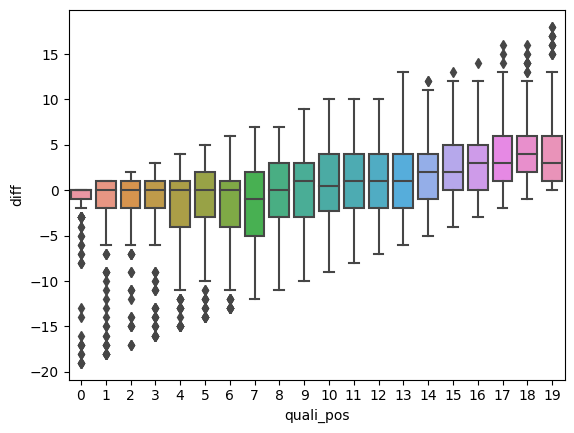

In [9]:
sns.boxplot(df_3_classes, x='quali_pos', y='diff')
plt.show()

In [77]:
def get_positions_of_other_drivers_in_race(df, race_id, driver_id):
    # Get all driver IDs in the specific race
    competing_driver_ids = df[df['raceId'] == race_id]['driverId'].unique()

    # Remove the specific driver ID from the list
    competing_driver_ids = competing_driver_ids[competing_driver_ids != driver_id]

    # Select the columns for the competing driver IDs
    competing_columns = [0 for i in range(20)]

    for competing in competing_driver_ids:
        quali_pos = df[df['driverId'] == competing]['quali_pos'].values[0]
        encoded_value = str(competing) + '|' + str(quali_pos)
        
        df.loc[(df['raceId'] == race_id) & (df['driverId'] == driver_id), f'competing_{quali_pos+1}'] = encoded_value

    

In [78]:
# Create an empty DataFrame with 20 columns
compet_columns = [f'competing_{i}' for i in range(1, 21)]
compet_df = pd.DataFrame(columns=compet_columns)

df_3_classes_compet = pd.concat([df_3_classes, compet_df], axis=1)

unique_race_ids = df_3_classes_compet['raceId'].unique()
count = 0

for i in unique_race_ids:
    for j in df[df['raceId'] == i]['driverId'].unique():
        count += 1
        get_positions_of_other_drivers_in_race(df_3_classes_compet, i, j)

In [79]:
from sklearn.preprocessing import LabelEncoder

# Perform label encoding
df_3_classes_compet_2 = df_3_classes_compet.copy()
for quali_pos in range(1, 21):
    encoder = LabelEncoder()
    df_3_classes_compet_2[f'competing_{quali_pos}'] = encoder.fit_transform(df_3_classes_compet_2[f'competing_{quali_pos}'])

In [81]:
x_variables_names = ['constructorId','driverId','quali_pos','wins','points','constructorPoints','constructorWins','pitDuration','driver_confidence','constructor_reliability','rain']
x_variables_names_compet = x_variables_names + [f'competing_{i}' for i in range(1, 21)]

In [10]:
X = df_3_classes[x_variables_names]
y = df_3_classes['position']

In [11]:
print(X.shape)
print(y.shape)

(4699, 11)
(4699,)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int32)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int32)

change the dataset to grab for the lookback the rows of the same driver in past races, maybe add the information of the position of all other drivers in a race to the row of a driver

In [13]:
# class LSTMDataset(Dataset):
#     def __init__(self, data, target, lookback):
#         self.data = data
#         self.target = target
#         self.lookback = lookback

#     def __len__(self):
#         return len(self.data) - self.lookback

#     def __getitem__(self, idx):
#         data_items = self.data[idx:idx+self.lookback]
#         target_item = self.target[idx+self.lookback - 1] # value to be predicted, we predict the last value of the lookback window, not the next one 
#         return data_items, target_item

class LSTMDataset(Dataset):
    def __init__(self, data, x_variables, y_variables, lookback):
        self.data = data

        self.data = data.sort_values(by=['date'])
        self.lookback = lookback

        #Convert column names to numeric indices
        self.x_indices = [data.columns.get_loc(col) for col in x_variables]
        self.y_indices = [data.columns.get_loc(col) for col in y_variables]

         # Group the data by 'driverId'
        self.grouped_data = self.data.groupby('driverId')

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        driverId = self.data.loc[idx, 'driverId']
        driver_data = self.grouped_data.get_group(driverId)

        # Get the integer positions of the driver's races
        #driver_positions = driver_data.index.tolist()

        # Find the index of the given race
        #idx_position = driver_positions.index(idx)

        idx_position = driver_data.index.get_loc(idx)

        start_idx = idx_position
        end_idx = idx_position + self.lookback

        # Adjust the end index if it exceeds the length of driver_data
        if end_idx >= len(driver_data):
            end_idx = len(driver_data) - 1

        data_items = driver_data.values[start_idx:end_idx, self.x_indices].astype(float)
        target_items = driver_data.values[end_idx - 1, self.y_indices].astype(float)

        if data_items.shape[0] < self.lookback:
            data_items = np.concatenate((np.zeros((self.lookback - data_items.shape[0], data_items.shape[1])), data_items), axis=0)
        
        data_tensor = torch.tensor(data_items, dtype=torch.float32)
        target_tensor = torch.tensor(target_items[0], dtype=torch.float32)

        return data_tensor, target_tensor

In [82]:
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
# train_dataset = LSTMDataset(X_train_tensor, y_train_tensor, 100)
# test_dataset = LSTMDataset(X_val_tensor, y_val_tensor, 100)

# lstm
train_data, test_data = train_test_split(df_3_classes_compet_2, test_size=0.3, shuffle=False)
train_dataset = LSTMDataset(df_3_classes_compet_2, x_variables_names_compet, ['position'], 4)
test_dataset = LSTMDataset(df_3_classes_compet_2, x_variables_names_compet, ['position'], 4)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [83]:
class MLP_driver_constructor(nn.Module):
    def __init__(self, inputs, outputs, hidden_layers):
        # hidden layers = [32, 64, 64, 64, 128, 128, 64, 64]
        super(MLP_driver_constructor, self).__init__()

        self.hidden_layers = nn.ModuleList([])

        prev_input = inputs

        for i in hidden_layers:
            self.hidden_layers.append(nn.Linear(prev_input, i))
            self.hidden_layers.append(nn.GELU())
            prev_input = i

        self.output_layer = nn.Linear(prev_input, outputs)
        
    def forward(self, x):
        for i in self.hidden_layers:
            x = i(x)
        x = self.output_layer(x) # logits
        
        return x

In [84]:
class LSTM_driver_constructor(nn.Module):
    def __init__(self, inputs, outputs, lstm_layers, lstm_size, hidden_layers):
        super(LSTM_driver_constructor, self).__init__()

        self.lstm_layers = lstm_layers

        prev_input = lstm_size

        self.lstm = nn.LSTM(inputs, prev_input, self.lstm_layers, batch_first=True, dropout=0, bidirectional=False)

        self.hidden_layers = nn.ModuleList([])

        for i in hidden_layers[1:]:
            self.hidden_layers.append(nn.Linear(prev_input, i))
            self.hidden_layers.append(nn.GELU())
            prev_input = i
        
        self.output_layer = nn.Linear(prev_input, outputs)

    def forward(self, x):
        # Initialize hidden and cell states
        # h0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size).to(x.device)
        # c0 = torch.zeros(self.lstm_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM layer
        out, _ = self.lstm(x)

        # Reshape output and pass through fully connected layer
        out = out[:, -1, :]
        
        for i in self.hidden_layers:
            out = i(out)
            
        out = self.output_layer(out) # logits

        return out

In [85]:
class EarlyStopper:
    def __init__(self, model, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.model = model

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            
            # Save the entire model
            torch.save(self.model, 'model_lstm_20_classes.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=100):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.history_loss = []
        self.history_val_loss = []
        self.history_f1 = []
        self.history_recall = []
        self.early_stopper = EarlyStopper(self.model, patience=5, min_delta=0.2)
        

    def to_device(self, data):
        if isinstance(data, (list, tuple)):
            return [self.to_device(x) for x in data]
        return data.to(self.device)

    def train_batch(self, inputs, labels):
        inputs = self.to_device(inputs)
        labels = self.to_device(labels)

        self.model.train()
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.long())
        loss.backward()
        self.optimizer.step()
        return loss.item(), outputs

    def validate_batch(self, inputs, labels):
        inputs = self.to_device(inputs)
        labels = self.to_device(labels)

        self.model.eval()
        with torch.no_grad():
            val_outputs = self.model(inputs)
            loss = self.criterion(val_outputs, labels.long())
            return loss.item(), val_outputs

    def train_epoch(self):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        y_true = []
        y_pred = []

        for inputs_batch, labels_batch in self.train_dataloader:
            loss, outputs = self.train_batch(inputs_batch, labels_batch)
            total_loss += loss

            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted.detach().cpu() == labels_batch.detach().cpu()).sum().item()
            total_samples += labels_batch.size(0)
            y_true.extend(labels_batch.tolist())
            y_pred.extend(predicted.tolist())

        avg_loss = total_loss / len(self.train_dataloader)
        accuracy = total_correct / total_samples
        f1 = f1_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')

        return avg_loss, accuracy, f1, recall

    def validate_epoch(self):
        val_loss = 0
        val_correct = 0
        val_samples = 0
        y_true = []
        y_pred = []

        for val_inputs, val_labels in self.val_dataloader:
            loss, val_outputs = self.validate_batch(val_inputs, val_labels)
            val_loss += loss

            _, val_predicted = torch.max(val_outputs, dim=1)
            val_correct += (val_predicted.detach().cpu() == val_labels.detach().cpu()).sum().item()
            val_samples += val_labels.size(0)
            y_true.extend(val_labels.tolist())
            y_pred.extend(val_predicted.tolist())

        avg_val_loss = val_loss / len(self.val_dataloader)
        val_accuracy = val_correct / val_samples
        val_f1 = f1_score(y_true, y_pred, average='weighted')
        val_recall = recall_score(y_true, y_pred, average='weighted')

        return avg_val_loss, val_accuracy, val_f1, val_recall

    def train(self):
        self.model.to(self.device)

        with tqdm(total=self.num_epochs, desc="Training", unit="epoch") as progress_bar:
            for epoch in range(self.num_epochs):
                # Training phase
                avg_loss, accuracy, f1, recall = self.train_epoch()

                # Validation phase
                avg_val_loss, val_accuracy, val_f1, val_recall = self.validate_epoch()

                # Append the loss, F1 score, and recall to history
                self.history_loss.append(avg_loss)
                self.history_val_loss.append(avg_val_loss)
                self.history_f1.append(f1)
                self.history_recall.append(recall)

                # Update the progress bar
                progress_bar.set_postfix(loss=avg_loss, accuracy=accuracy, f1=f1, recall=recall,
                                         val_loss=avg_val_loss, val_accuracy=val_accuracy, val_f1=val_f1, val_recall=val_recall)
                progress_bar.update(1)

                if self.early_stopper.early_stop(avg_val_loss):
                    print("Early stopping")
                    break

    def predict(self, dataloader):
        self.model.to(self.device)
        self.model.eval()
        predictions = []
        true_labels = []
        
        with torch.no_grad():
             for val_inputs, val_labels, in dataloader:
                val_inputs = self.to_device(val_inputs)
                outputs = self.model(val_inputs)
                _, predicted_labels = torch.max(outputs, dim=1)
                predicted_labels = predicted_labels.cpu().numpy()
                val_labels = val_labels.cpu().numpy()
                predictions.extend(predicted_labels.tolist())
                true_labels.extend(val_labels.tolist())
        
        return predictions, true_labels


In [89]:
# Create the model instance
model = LSTM_driver_constructor(inputs=len(x_variables_names_compet), outputs=20, lstm_layers=3, lstm_size=64, hidden_layers=[64, 128, 64])

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


In [90]:
model_trainer = Trainer(model, train_dataloader, test_dataloader, criterion, optimizer, device, num_epochs=500)

In [91]:
model_trainer.train()

Training:   0%|          | 2/500 [00:13<55:18,  6.66s/epoch, accuracy=0.0837, f1=0.033, loss=2.95, recall=0.0837, val_accuracy=0.0707, val_f1=0.0228, val_loss=2.95, val_recall=0.0707]


KeyboardInterrupt: 

In [ ]:
def print_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Normalized Confusion Matrix")
    plt.show()


In [ ]:
def plot_loss_curves(history_loss, history_val_loss):
    sns.lineplot(x=range(len(history_loss)), y=history_loss, label='Training Loss')
    sns.lineplot(x=range(len(history_val_loss)), y=history_val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

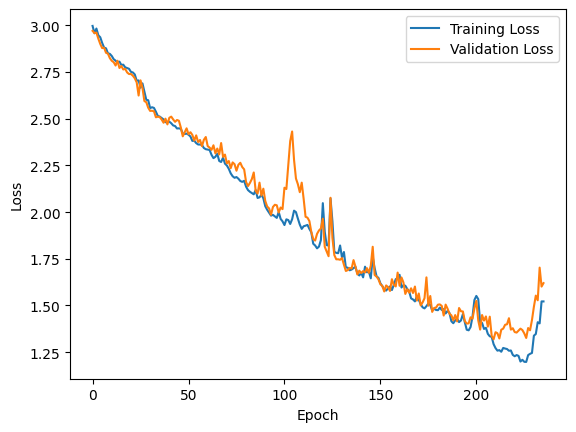

In [ ]:
plot_loss_curves(model_trainer.history_loss, model_trainer.history_val_loss)

In [ ]:
model_best = torch.load("model_lstm_20_classes_v1.pt")
model_best_trainer = Trainer(model_best, train_dataloader, test_dataloader, criterion, optimizer, device, num_epochs=500)

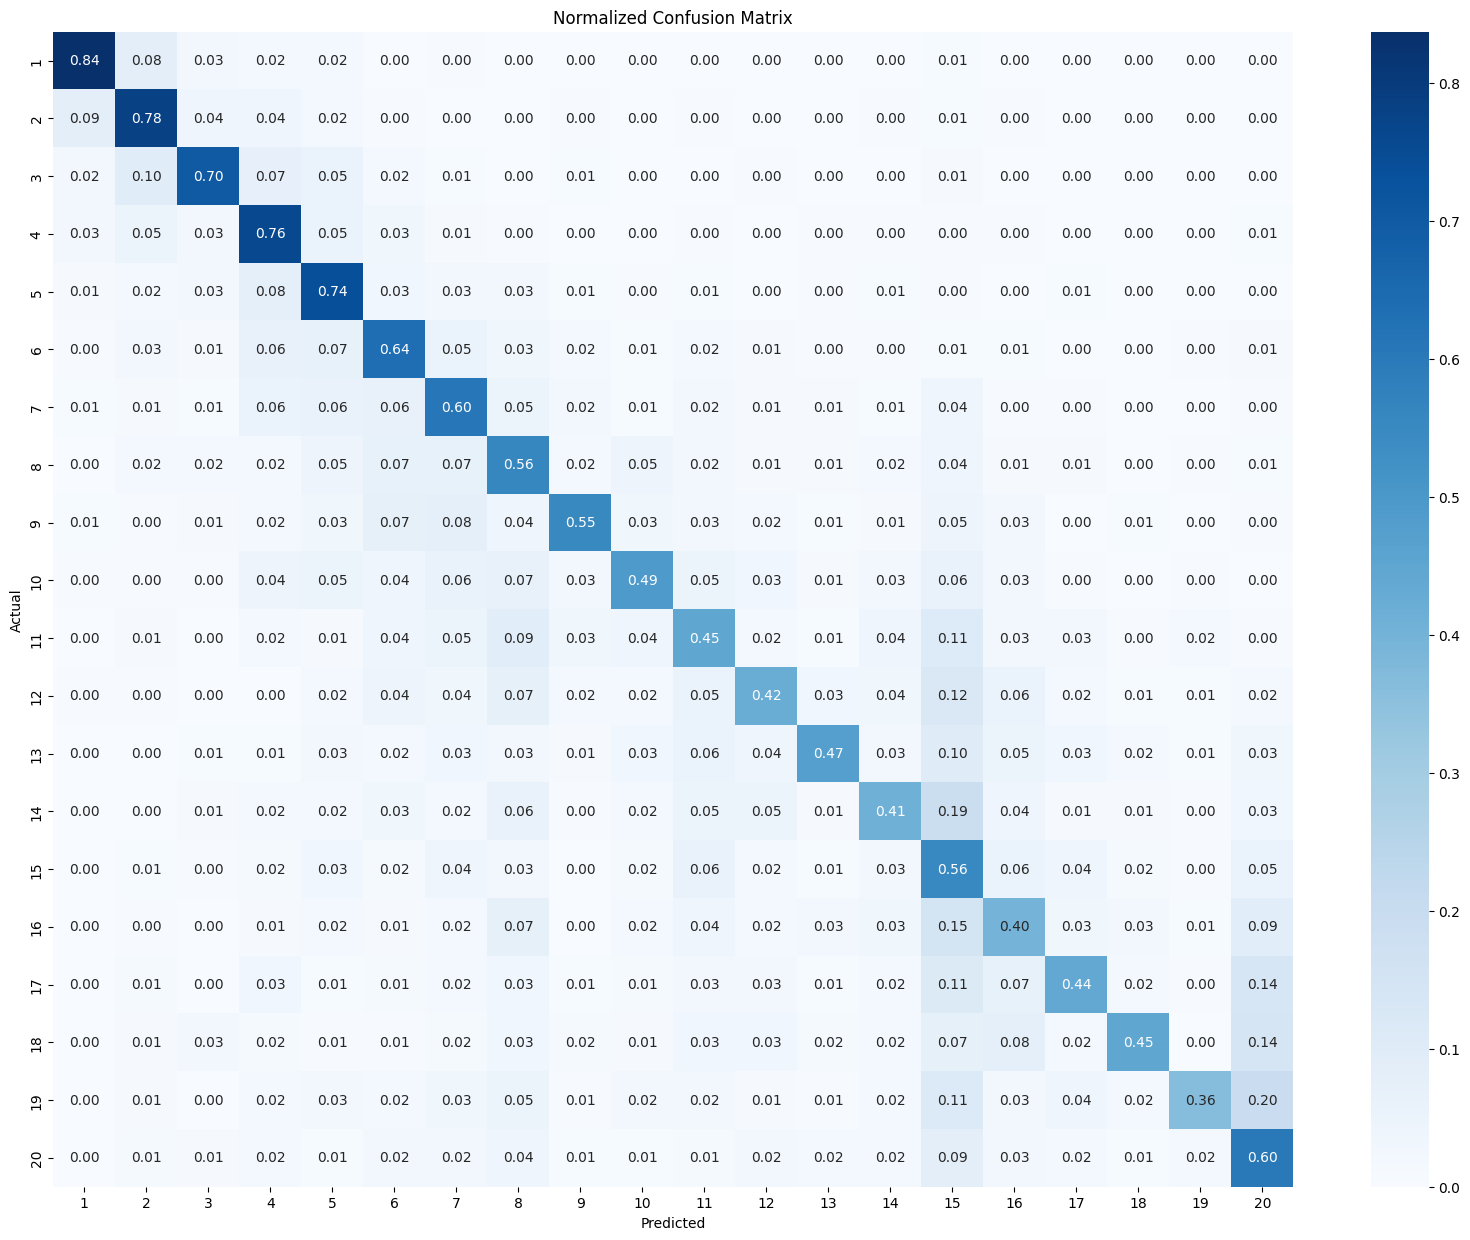

In [ ]:
test_predictions, test_true = model_best_trainer.predict(test_dataloader)

print_confusion_matrix(test_true, test_predictions, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])